In [2]:
import threeDrebuild 
acad=threeDrebuild.acad
lines=threeDrebuild.lines
arcs=threeDrebuild.arcs



其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDbRotatedDimension
其他对象: AcDb2LineAngularDimension
主视图有 90 条线段，32 个点
顶视图有 100 条线段，48 个点
右视图有 102 条线段，40 个点
3D点生成完毕，共 104 个点


In [3]:

import unfold.build_graph
import importlib
importlib.reload(unfold.build_graph)
from unfold.build_graph import get_graph
G_without_arcs,center_SEpair_map,center_arc_map=get_graph(lines,arcs)

第 1 个连通分量有 12 个节点，包含的弧有 4 条
第 2 个连通分量有 12 个节点，包含的弧有 2 条
第 3 个连通分量有 12 个节点，包含的弧有 1 条
第 4 个连通分量有 12 个节点，包含的弧有 1 条
第 5 个连通分量有 12 个节点，包含的弧有 1 条
第 6 个连通分量有 8 个节点，包含的弧有 1 条


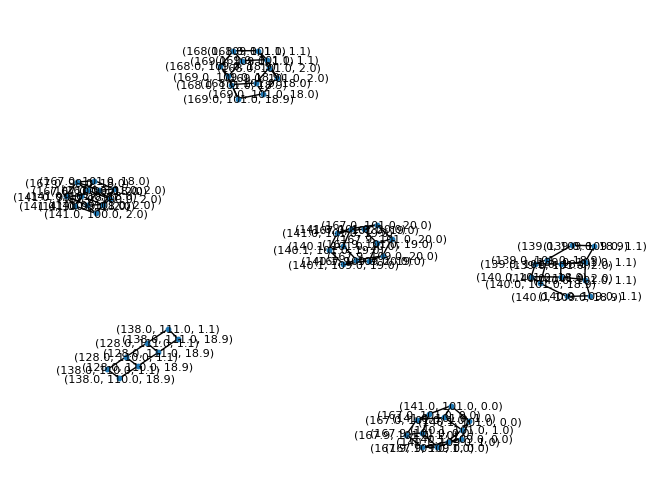

In [4]:
import unfold.build_compoment
import importlib
importlib.reload(unfold.build_compoment)
from unfold.build_compoment import get_component

component_arc_map,component_id_map,start_id=get_component(G_without_arcs,center_SEpair_map)



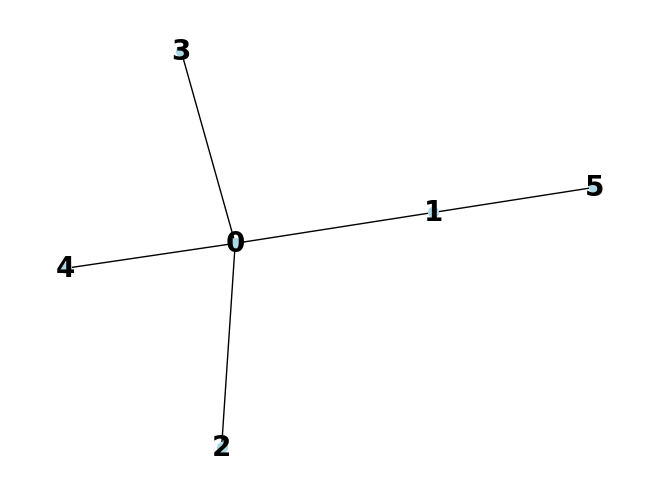

In [5]:
import unfold.build_compoment_graph
import importlib
importlib.reload(unfold.build_compoment_graph)
from unfold.build_compoment_graph import get_compoment_graph
graph=get_compoment_graph(component_arc_map)


In [ ]:
from collections import deque
import networkx as nx
import transforms3d
import numpy as np
from interferce import *
from pyautocad import Autocad, APoint
# 定义一个函数transform_edge，用于转换边
def translation_matrix(translation):
    mat = np.eye(4)
    mat[:3, 3] = translation
    return mat
def rotation_matrix_from_axis_angle(axis, angle):
    # 使用 transforms3d 创建 3x3 旋转变换矩阵
    R = transforms3d.axangles.axangle2mat(axis, angle)
    # 将其扩展为 4x4 齐次变换矩阵
    mat = np.eye(4)
    mat[:3, :3] = R
    return mat
def transform_edge(edge_name, last_transform,component_points):
    arc:Arc3D = center_arc_map[edge_name]
    center = np.array(arc.center)  # 将 center 转换为 numpy 数组
    normal = np.array(arc.normal)  # 将 normal 转换为 numpy 数组
    start_point = arc.start_point
    start_point_in_component = start_point in component_points

    rangle = arc.end_angle-arc.start_angle if  start_point_in_component else arc.start_angle-arc.end_angle # 旋转
    start_angle = arc.start_angle if start_point_in_component else arc.end_angle
    end_angle = arc.end_angle if start_point_in_component else arc.start_angle
    if start_point_in_component:
        print(f"in,      {start_angle*180/np.pi}      {end_angle*180/np.pi}     {rangle*180/np.pi}")
    else:
        print(f"not_in,  {start_angle*180/np.pi}      {end_angle*180/np.pi}     {rangle*180/np.pi}")
    # 创建绕法向量在中心点的旋转变换矩阵
    nomal_name=edge_name[-1]
   # print(f"normal: {nomal_name}")
    if nomal_name=="Z": rangle=- rangle
    rotation_matrix = rotation_matrix_from_axis_angle(normal, rangle)
    
    center_translation_matrix =translation_matrix(center)
    
    center_inverse_translation_matrix =translation_matrix(-center)
    # 组合变换：先平移到原点，旋转，再平移回中心
    new_transform = np.dot(center_translation_matrix, np.dot(rotation_matrix,center_inverse_translation_matrix))

    # 将新的变换矩阵与之前的变换矩阵组合
    final_transform = np.dot(last_transform, new_transform)

    return final_transform
def excuse_transform(node, component_edges, last_transform):
    for edge in component_edges:
        # 获取边的两个顶点
        u, v = edge
        u_homogeneous = np.append(u, 1)
        v_homogeneous = np.append(v, 1)
        z_translation_matrix =translation_matrix([0, 0, 50])
        z_last_transform = np.dot(z_translation_matrix, last_transform)
        transform_u=np.dot(z_last_transform, u_homogeneous)
        transform_v=np.dot(z_last_transform, v_homogeneous)
      
        transform_u = transform_u[:3]
        transform_v = transform_v[:3]

        x1, y1, z1 = transform_u.tolist()
        x2, y2, z2 = transform_v.tolist()
        #其中 1 是红色，2 是黄色，3 是绿色，4 是蓝色，5 是紫色，6 是青色，7 是灰色，8 是白色
        line=acad.model.AddLine(APoint(x1, y1, z1), APoint(x2, y2, z2))
        line.color=node




    pass
def dfs(graph: nx.Graph, node, visited, last_transform):
    # 访问当前节点
    print(node)
    visited.add(node)
    component_edges=component_id_map[node]["component_edges"]
    component_points=component_id_map[node]["component_points"]
    excuse_transform(node, component_edges, last_transform)
    # 遍历邻居节点
    for neighbor in graph[node]:
        if neighbor not in visited:
            edge_data = graph.get_edge_data(node, neighbor)
            edge_name = edge_data.get('name', 'No name')
            print(f"Edge: {node} -> {neighbor}, Name: {edge_name}")
            
            # 变换边并更新 last_transform
            new_transform = transform_edge(edge_name, last_transform,
               component_points                          )
           
            
            # 递归访问邻居节点
            dfs(graph, neighbor, visited, new_transform)

print("其中 1 是红色，2 是黄色，3 是绿色，4 是蓝色，5 是紫色，6 是青色，7 是灰色，8 是白色")
visited = set()
last_transform = np.eye(4)  # 初始变换矩阵
dfs(graph, start_id, visited, last_transform)

其中 1 是红色，2 是黄色，3 是绿色，4 是蓝色，5 是紫色，6 是青色，7 是灰色，8 是白色
2
Edge: 2 -> 0, Name: (101.0, 18.0)X
not_in,  180.0      90.0     -90.0
normal: X
0
Edge: 0 -> 1, Name: (141.0, 101.0)Z
not_in,  -90.0      180.0     270.0
normal: Z
1
Edge: 1 -> 5, Name: (138.0, 109.0)Z
in,      0.0      90.0     90.0
normal: Z
5
Edge: 0 -> 3, Name: (101.0, 2.0)X
not_in,  -90.0      180.0     270.0
normal: X
3
Edge: 0 -> 4, Name: (167.0, 101.0)Z
in,      -90.0      0.0     90.0
normal: Z
4
